# Requirement 1: Stochastic Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
# pricing parameters
prices = np.linspace(0, 1, 100)
n_customers = 100

conversion_probability = lambda p: 1-p
cost = 0.5
min_price, max_price = 0, 1
reward_function = lambda price, n_sales: (price-cost)*n_sales

In [3]:
# auction parameters
n_advertisers = 6
q = np.array([0.9, 0.7, 0.5, 0.6, 0.85, 0.65]) # ad quality
v = np.array([1.0, 1.0, 1.0, 0.85, 1.0, 0.9]) # advertisers value per click
B = 20
n_auctions = 300

other_bids = np.random.uniform(0, 10*B/n_auctions, size = (n_advertisers-1, n_auctions))
m_t = other_bids.max(axis=0) ### maximum bid at every round, NOT IN EXPECTATION

n_slots = 3
lmb = np.sort(np.array([0.6, 0.7, 0.9]))
K=11
available_bids = np.array([round(i, 1) for i in np.linspace(0,1,K)])

## Environments

In [4]:
class Environment:
    def __init__(self):
        pass

    def round(self, a_t):
        pass

In [5]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t)) # number of sells
        r_t = (p_t - self.cost)*d_t # reward
        return d_t, r_t

In [6]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [7]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [8]:
# truthful multiple slot auction
class VCGAuction(Auction):
    def __init__(self, ctrs, lambdas):
        self.ctrs = ctrs
        self.lambdas = lambdas
        self.n_adv = len(self.ctrs)
        self.n_slots = len(self.lambdas)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.n_slots:]
        winners_values = adv_values[winners]
        return winners, winners_values
    
    def get_payments_per_click(self, winners, values, bids):
        payments_per_click = np.zeros(self.n_slots)
        for i,w in enumerate(winners):
            Y = sum(np.delete(values, i)*self.lambdas[-self.n_slots+1:])
            X = sum(np.delete(values*self.lambdas, i))
            payments_per_click[i] = (Y-X)/(self.lambdas[i]*self.ctrs[w])
        return payments_per_click.round(2)

## Agents

In [9]:
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        # TDOD set parameters??
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

In [10]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

In [ ]:
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        # TDOD set parameters??
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

## Interaction

In [15]:
T = 200

pricingAgent = GPUCBAgent(T)
pricingEnv = PricingEnvironment(conversion_probability, cost)

learning_rate = 1/np.sqrt(n_auctions) # from theory
auctionEnvTruthful = VCGAuction(q,lmb)

agent_rewards = np.array([])
expected_agent_reward = np.array([])

counter = 0

for t in range(T):
    p_t = pricingAgent.pull_arm()
    auctionAgentTruthful = MultiplicativePacingAgent(valuation=p_t, budget=B, T=n_auctions, eta=learning_rate)
    n_users = 0
    for u in range(n_auctions):
        my_bid = auctionAgentTruthful.bid()
        all_bids = np.append(my_bid, np.transpose(other_bids)[u].ravel())
        winners, payments_per_click = auctionEnvTruthful.round(bids=all_bids)
        ctr = 0
        if 0 in winners:
            my_slot = np.where(winners == 0)[0]
            c_t = payments_per_click[my_slot]
            f_t = v[0]-c_t
            ctr = lmb[my_slot]*q[0]
        else:
            c_t,f_t = 0,0
        auctionAgentTruthful.update(f_t, c_t)
        if random.random() < ctr:
            n_users += 1
    d_t, r_t = pricingEnv.round(p_t, n_users)
    agent_rewards = np.append(agent_rewards, r_t)
    pricingAgent.update(r_t)


In [16]:
# let's compute the clairvoyant
profit_curve = reward_function(prices, n_auctions*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

C:\Users\Amelie\AppData\Local\Temp\ipykernel_11040\893357982.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(cumulative_regret/times, label='Cumulative Regret over time')


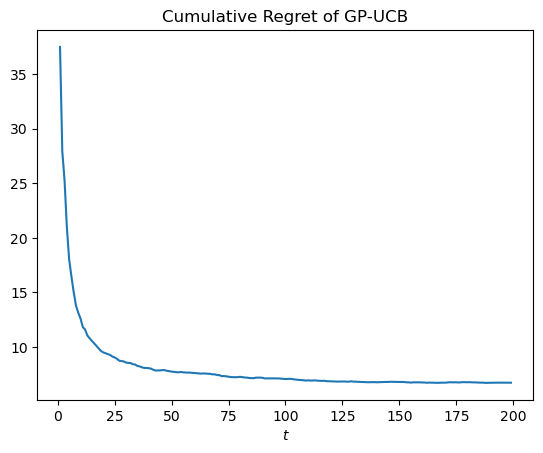

In [18]:
cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
plt.figure()
# plt.plot(cumulative_regret, label='Cumulative Regret')
times = range(T)
plt.plot(cumulative_regret/times, label='Cumulative Regret over time')
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();

In [ ]:
T = 200

pricingAgent = GPUCBAgent(T)
pricingEnv = PricingEnvironment(conversion_probability, cost)

auction = VCGAuction(q, lmb)

agent_rewards = np.array([])
expected_agent_reward = np.array([])

counter = 0

for t in range(T):
    p_t = pricingAgent.pull_arm()
    UCBAuctionAgent = UCBBiddingAgent(bids_set=available_bids, valuation=p_t, budget=B, T=n_auctions)
    n_users = 0
    for u in range(n_auctions):
        my_bid = UCBAuctionAgent.bid()
        all_bids = np.append(my_bid, np.transpose(other_bids)[u].ravel())
        winners, payments_per_click = auction.round(bids=all_bids)
        ctr = 0
        if 0 in winners:
            my_slot = np.where(winners == 0)[0]
            c_t = payments_per_click[my_slot]
            f_t = p_t-c_t
            ctr = lmb[my_slot]*q[0]
        else:
            c_t,f_t = 0,0
        UCBAuctionAgent.update(f_t, c_t)
        if random.random() < ctr:
            n_users += 1
    d_t, r_t = pricingEnv.round(p_t, n_users)
    agent_rewards = np.append(agent_rewards, r_t)
    pricingAgent.update(r_t)

In [ ]:
# let's compute the clairvoyant
profit_curve = reward_function(prices, n_auctions*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

In [ ]:
cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
plt.figure()
# plt.plot(cumulative_regret, label='Cumulative Regret')
times = range(T)
plt.plot(cumulative_regret/times, label='Cumulative Regret over time')
plt.title('Cumulative Regret of GP-UCB with UCB-like bidding algorithm')
plt.xlabel('$t$')
plt.show();